In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/Pokemon-GAN

/content/drive/My Drive/Pokemon-GAN


In [3]:
ls

Final_DCGAN.ipynb  images/  output/  pokemon.csv  pokemon-images-and-types.zip


In [4]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob
import cv2
#import xml.etree.ElementTree as et 
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
#!unzip "/content/drive/My Drive/Pokemon-GAN/pokemon-images-and-types.zip"

Archive:  /content/drive/My Drive/Pokemon-GAN/pokemon-images-and-types.zip
  inflating: images/images/abomasnow.png  
  inflating: images/images/abra.png  
  inflating: images/images/absol.png  
  inflating: images/images/accelgor.png  
  inflating: images/images/aegislash-blade.png  
  inflating: images/images/aerodactyl.png  
  inflating: images/images/aggron.png  
  inflating: images/images/aipom.png  
  inflating: images/images/alakazam.png  
  inflating: images/images/alomomola.png  
  inflating: images/images/altaria.png  
  inflating: images/images/amaura.png  
  inflating: images/images/ambipom.png  
  inflating: images/images/amoonguss.png  
  inflating: images/images/ampharos.png  
  inflating: images/images/anorith.png  
  inflating: images/images/araquanid.jpg  
  inflating: images/images/arbok.png  
  inflating: images/images/arcanine.png  
  inflating: images/images/arceus.png  
  inflating: images/images/archen.png  
  inflating: images/images/archeops.png  
  inflating:

In [0]:
ls

images/  pokemon.csv  pokemon-images-and-types.zip  Untitled0.ipynb


In [0]:
#!pwd
image_path = "/content/drive/My Drive/Pokemon-GAN/images/images"

In [0]:
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np


def read_image(file):
    image = open_image(image_path + '/' + file)
    image = normalize_image(image)
    return image


def open_image(file,color=(255, 255, 255)):
    image = Image.open(file).convert('RGBA')
    #image = image.crop(bounds)
    image = alpha_to_color(image, color=(255, 255, 255))
    image = image.resize((64, 64),Image.ANTIALIAS)
    return np.array(image)

def alpha_to_color(image, color=(255, 255, 255)):
  image.load()  # needed for split()
  background = Image.new('RGB', image.size, color)
  background.paste(image, mask=image.split()[-1])  # 3 is the alpha channel
  return background

# Normalization, [-1,1] Range
def normalize_image(image):
    image = np.asarray(image, np.float32)
    image = image / 127.5 - 1
    return img_to_array(image)


# Restore 0..255 Range
def denormalize_image(image):
    return ((image+1)*127.5).astype(np.uint8)

In [0]:
def load_images():
    images = []
    print('Loading Images')
    for pokemon in os.listdir(image_path): 
      #print(pokemkon)
      poke_img = read_image(pokemon)
      images.append(poke_img)

    return np.array(images)

In [0]:
pokemon_images = load_images()

Loading Images


In [0]:
print(pokemon_images[0].shape)

(64, 64, 3)


In [0]:
print(len(pokemon_images))

809


In [0]:
sum(item.size for item in pokemon_images)

9940992

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


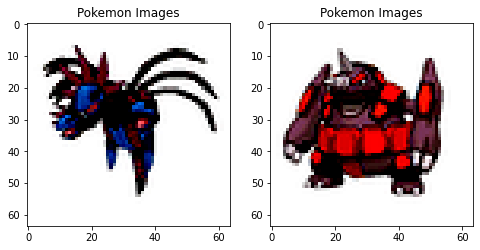

In [0]:
f, axes = plt.subplots(1,2, figsize=(8,8))
#plt.subplots_adjust() #hspace=0.5

for index in range(2):
    imgs = np.random.randint(0, len(pokemon_images)-1)
    axes[index,].imshow(pokemon_images[imgs])
    axes[index,].set_title("Pokemon Images")

In [0]:
pokemon_images[0].min()

-0.9764706

In [0]:
def generate_noise(size):
    return np.random.normal(0, 1, size=[size, 100])


In [0]:
from tensorflow.keras.preprocessing.image import array_to_img

def save_images(generator):
    if not os.path.exists('output'):
        os.mkdir('output')

    noise = generate_noise(10000)
    generated_images = generator.predict(noise)

    for i in range(generated_images.shape[0]):
        image = denormalize_image(generated_images[i])
        image = array_to_img(image)
        image.save( 'output/' + str(i) + '.png')

    shutil.make_archive('images', 'zip', 'output')

In [0]:
from PIL import Image, ImageDraw
import glob
frames = []

for image in glob.glob("output/*.png"):#os.listdir("output/"):
    #print(image)
    frames.append(Image.open(image))

frames[0].save('GAN_Result.gif', format='GIF', append_images=frames[1:], save_all=True, duration=400, loop=0)

In [0]:
from tensorflow.keras.layers import Input,Dense,Reshape,Flatten,Dropout,LeakyReLU,Conv2D,BatchNormalization,UpSampling2D,Reshape,Conv2DTranspose
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
INPUT_SIZE = 100

In [0]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=8*8*512,input_dim=100))
    generator.add(BatchNormalization(momentum=0.1, epsilon=1e-05))
    generator.add(LeakyReLU())

    generator.add(Reshape((8,8,512)))

    generator.add(Conv2DTranspose(512, 4, strides=1, padding='same'))
    generator.add(BatchNormalization(momentum=0.1, epsilon=1e-05))
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(256, 4, strides=2, padding='same'))
    generator.add(BatchNormalization(momentum=0.1, epsilon=1e-05))
    generator.add(LeakyReLU())

    generator.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
    generator.add(BatchNormalization(momentum=0.1, epsilon=1e-05))
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(64, 4, strides=2, padding='same'))
    generator.add(BatchNormalization(momentum=0.1, epsilon=1e-05))
    generator.add(LeakyReLU())
    
    generator.add(Conv2DTranspose(3, 4, strides=1, activation='tanh', padding='same'))
        
    generator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    generator.summary()
    
    return generator


def create_discriminator():
    discriminator=Sequential()

    discriminator.add(Conv2D(64, kernel_size = 4, strides = 2, padding = 'same', input_shape=(64,64,3)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, kernel_size = 4, strides = 2, padding = 'same'))
    discriminator.add(LeakyReLU(0.2))

    discriminator.add(Conv2D(256, kernel_size = 4, strides = 2, padding = 'same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(512, kernel_size = 4, strides = 2, padding = 'same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(1, kernel_size = 4, strides = 1, padding = 'same'))

    discriminator.add(Flatten())
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    discriminator.summary()
    
    return discriminator

def create_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = Input(shape=(100,))
    generator_output = generator(gan_input)
    gan_output = discriminator(generator_output)

    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    gan.summary()
    
    return gan

In [0]:
import matplotlib.pyplot as plt


def plot_images(epoch, generator, size=25, dim=(5,5), figsize=(10,10)):
    noise = generate_noise(size)
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(denormalize_image(generated_images[i]), interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    #plt.savefig('figures/image_' + str(epoch) + '.png')
    
    
def plot_loss(epoch, g_losses, d_losses):
    plt.figure(figsize=(10,5))
    plt.title("Loss, Epochs 0-" + str(epoch))
    plt.plot(g_losses,label="Generator")
    plt.plot(d_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    #plt.savefig('figures/loss_' + str(epoch) + '.png')


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
batch_normalization_5 (Batch (None, 32768)             131072    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 512)         4194816   
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 512)        

  0%|          | 0/25 [00:00<?, ?it/s]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 64, 64, 3)         10395331  
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 2764754   
Total params: 13,160,085
Trainable params: 10,327,875
Non-trainable params: 2,832,210
_________________________________________________________________
--------------- Epoch 1 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 6 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 7 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 8 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 9 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 11 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 12 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 13 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 14 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 15 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 16 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 17 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 18 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 19 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 20 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 21 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 22 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 23 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 24 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 25 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 26 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 27 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 28 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 29 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 30 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 31 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 32 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 33 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 34 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 35 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 36 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 37 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 38 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 39 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 40 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 41 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 42 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 43 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 44 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 45 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 46 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 47 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 48 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 49 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 50 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 51 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 52 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 53 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 54 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 55 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 56 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 57 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 58 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 59 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 60 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 61 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 62 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 63 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 64 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 65 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 66 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 67 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 68 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 69 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 70 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 71 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 72 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 73 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 74 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 75 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 76 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 77 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 78 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 79 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 80 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 81 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 82 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 83 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 84 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 85 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 86 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 87 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 88 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 89 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 90 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 91 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 92 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 93 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 94 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 95 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 96 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 97 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 98 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 99 ---------------


  0%|          | 0/25 [00:00<?, ?it/s]

--------------- Epoch 100 ---------------


100%|██████████| 25/25 [02:12<00:00,  5.30s/it]


NameError: ignored

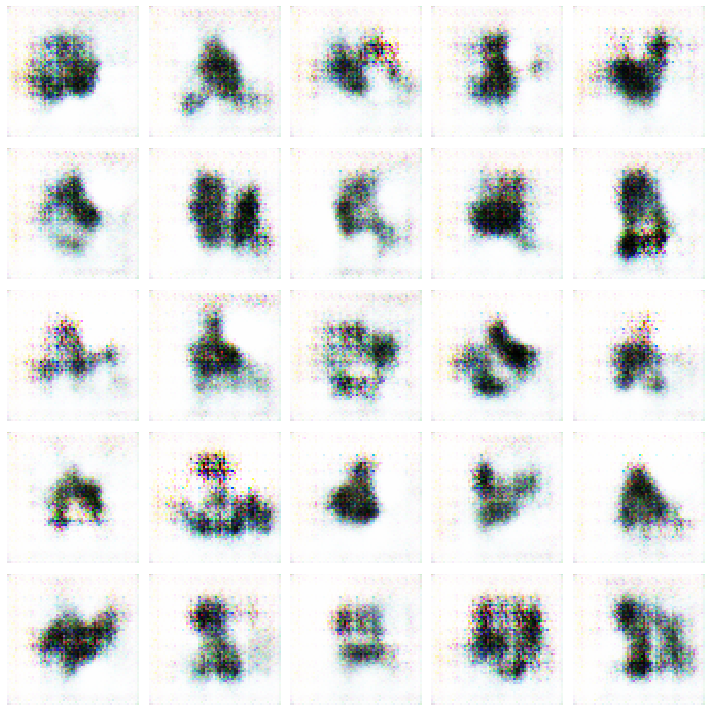

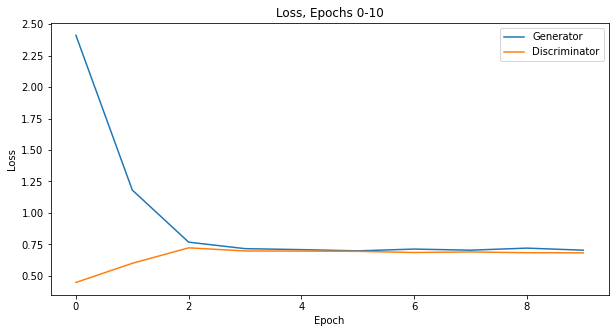

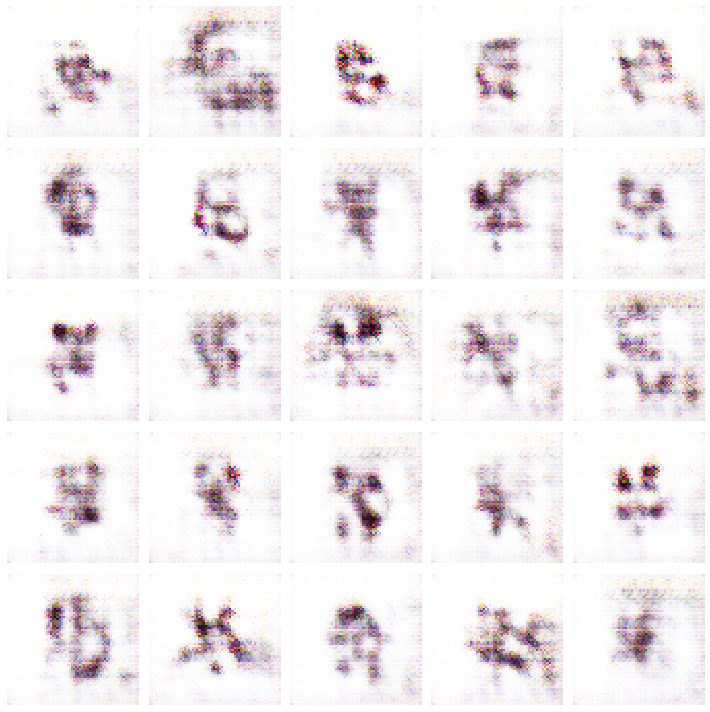

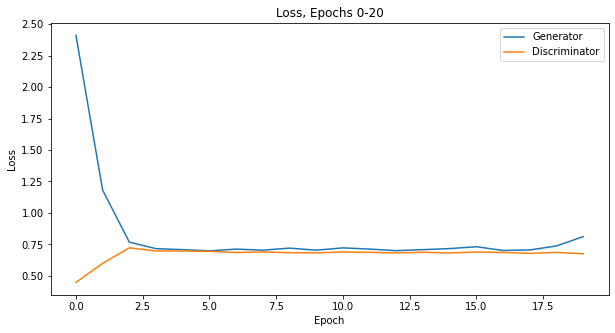

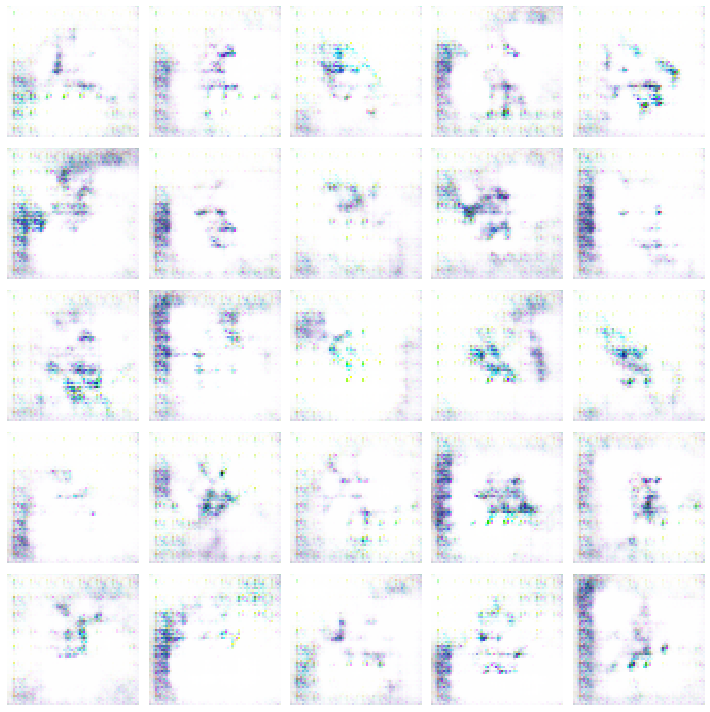

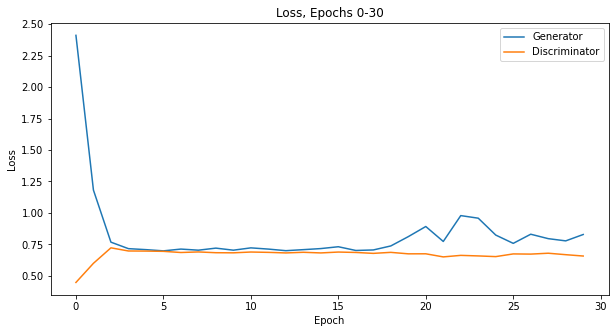

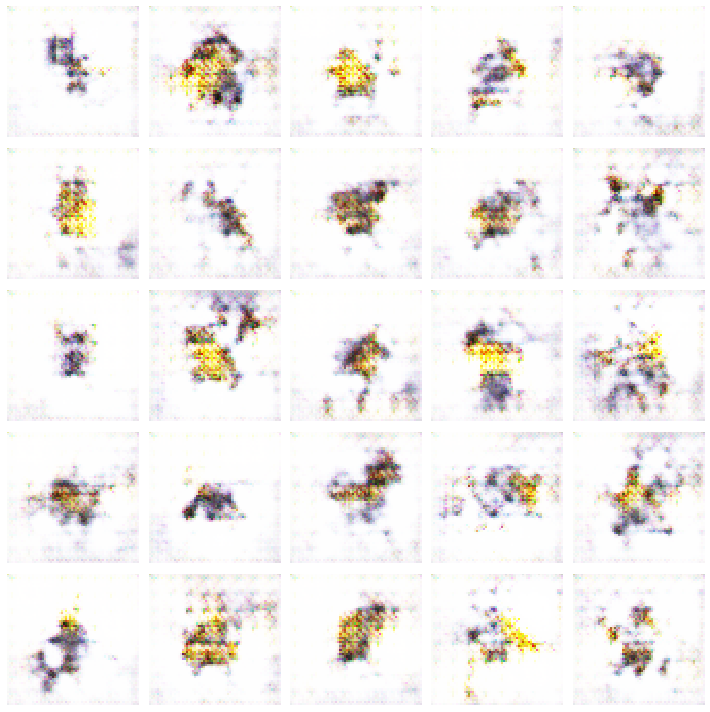

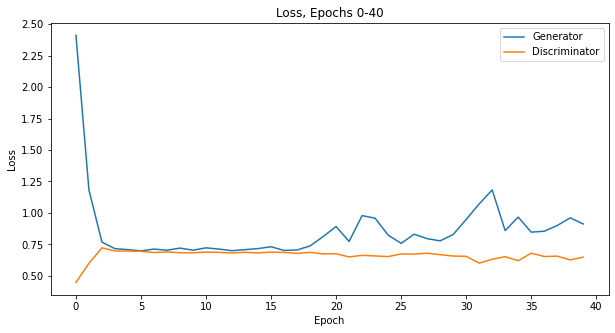

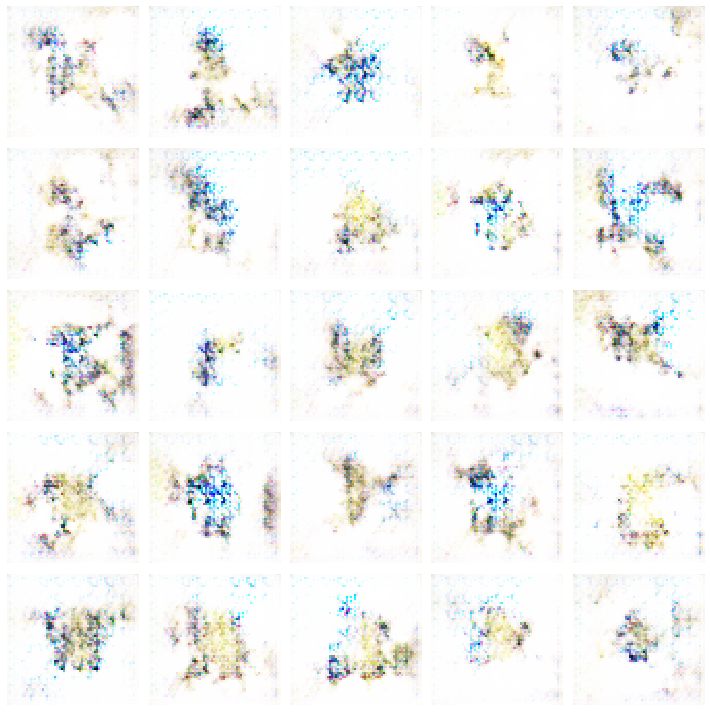

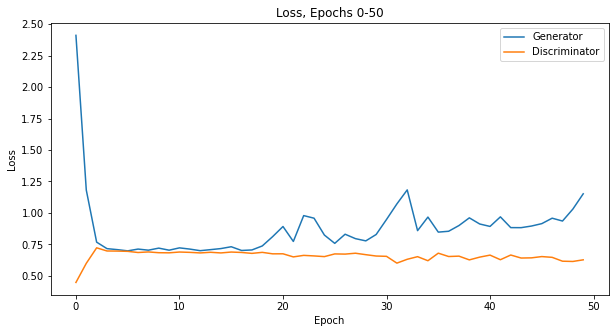

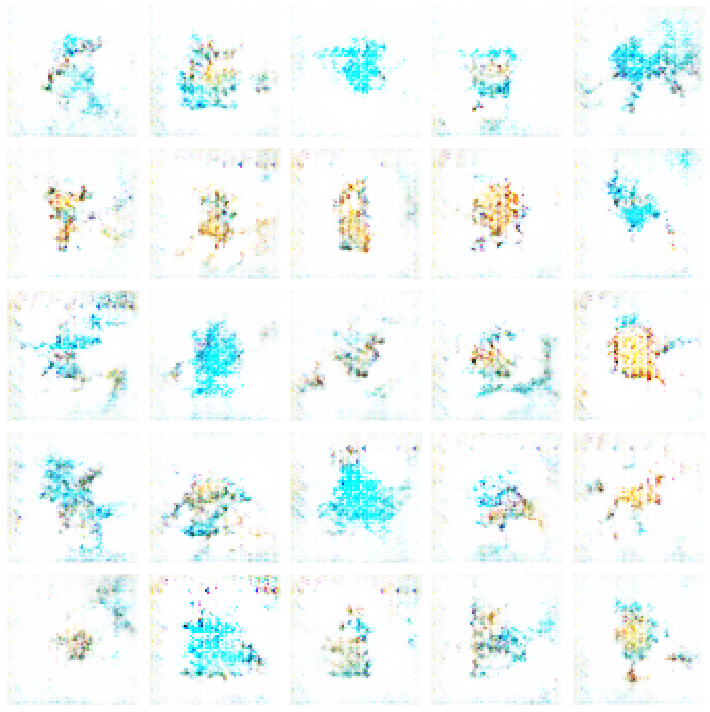

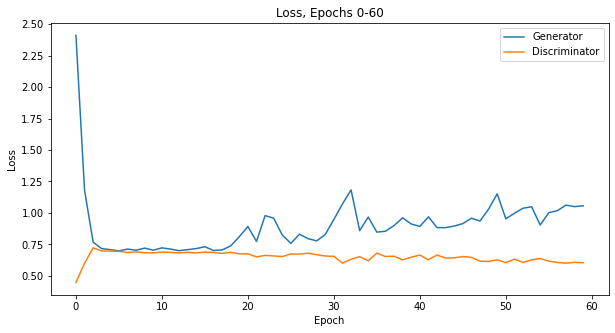

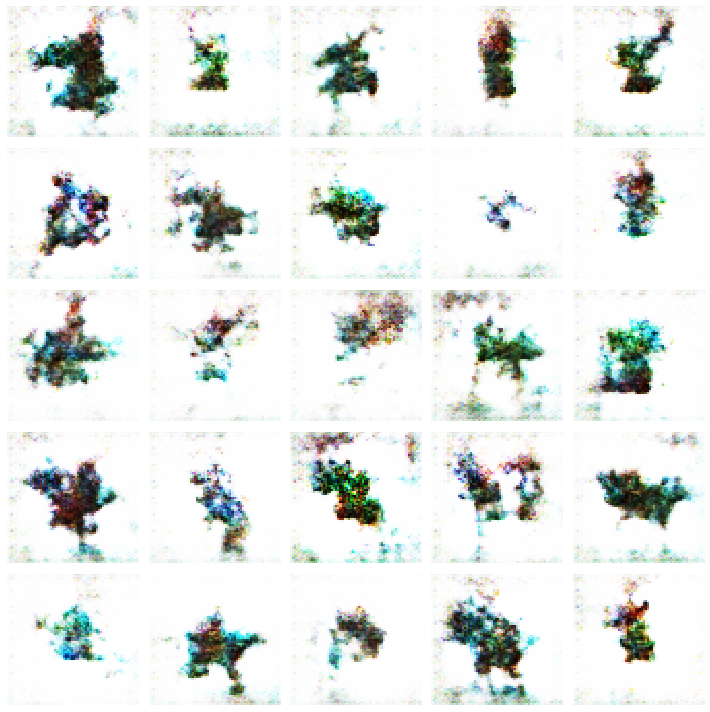

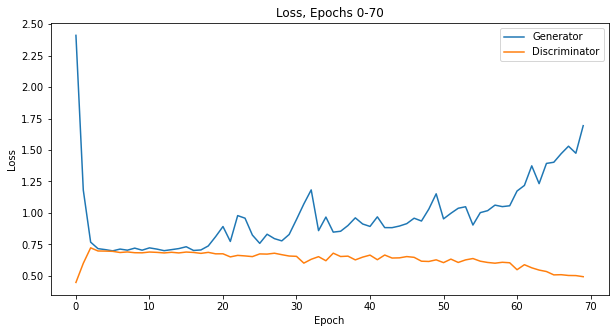

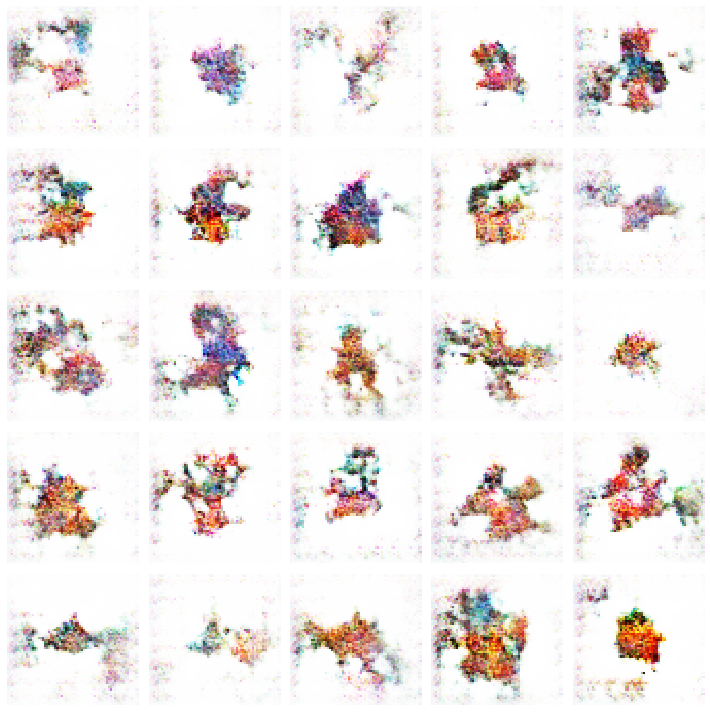

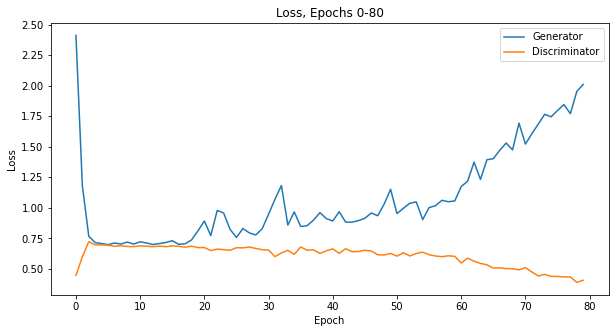

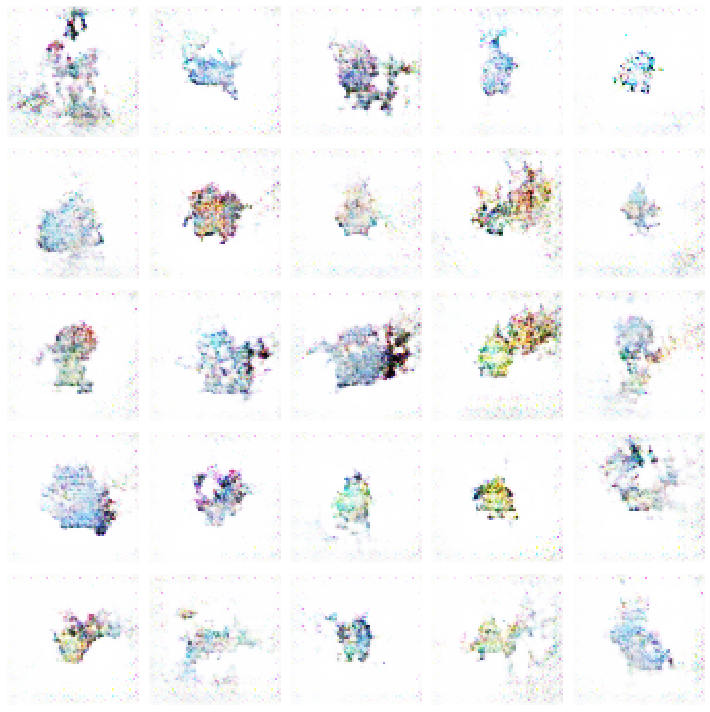

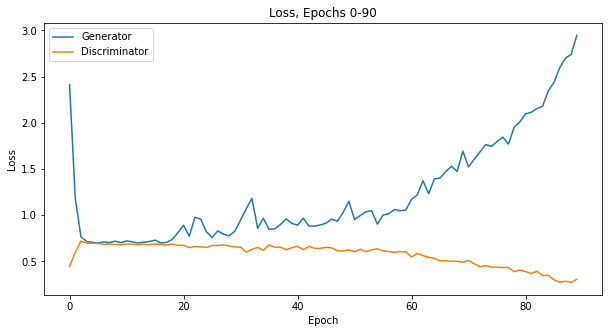

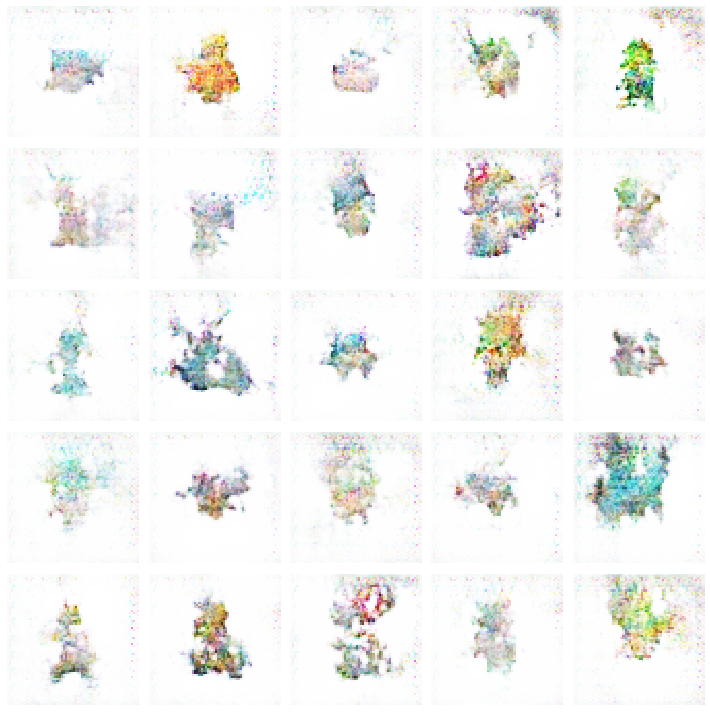

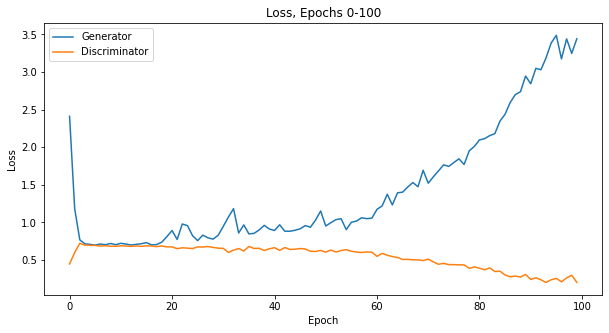

In [0]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt



PLOT_FRECUENCY = 10


def training(epochs=1, batch_size=32):
    #Loading Data
    """x_train = load_images()
    for i,item in enumerate(x_train):
        if item.size != 12288:
            #print(i, item.shape)
            x_train.remove(item)
    print(len(x_train))"""
    #x_train = np.array(x_train)  
    x_train = pokemon_images
    batches = x_train.shape[0] / batch_size

    # Creating GAN
    generator = create_generator()
    discriminator = create_discriminator()
    gan = create_gan(generator, discriminator)
    
    # Adversarial Labels
    y_valid = np.ones(batch_size)
    y_fake = np.zeros(batch_size)

    discriminator_loss, generator_loss = [], []

    for epoch in range(1, epochs+1):
        print('-'*15, 'Epoch', epoch, '-'*15)
        g_loss = 0
        d_loss = 0

        for _ in tqdm(range(int(batches))):
            # Random Noise and Images Set
            noise = generate_noise(batch_size)
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate Fake Images
            generated_images = generator.predict(noise)
            
            # Train Discriminator (Fake and Real)
            discriminator.trainable = True
            d_valid_loss = discriminator.train_on_batch(image_batch, y_valid)
            d_fake_loss = discriminator.train_on_batch(generated_images, y_fake)            

            d_loss += (d_fake_loss + d_valid_loss)/2
            
            # Train Generator
            noise = generate_noise(batch_size)
            discriminator.trainable = False
            g_loss += gan.train_on_batch(noise, y_valid)
            
        discriminator_loss.append(d_loss/batches)
        generator_loss.append(g_loss/batches)
            
        if epoch % PLOT_FRECUENCY == 0:
            plot_images(epoch, generator)
            plot_loss(epoch, generator_loss, discriminator_loss)

    save_images(generator)


if __name__ == '__main__':
    training(epochs=100)